In [1]:
import os
import xgboost as xgb
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt

pd.set_option("display.max_columns", None)

In [2]:
# Load the data into a pandas DataFrame
# data = pd.read_csv('../data/uk/processed/full_preprocessed.csv')
UK_DATA_PATH = '../data/uk/'
uk_csv_files = []
for file in os.listdir(UK_DATA_PATH + "raw/"):
    d = os.path.join(UK_DATA_PATH + "raw/", file)
    if os.path.isdir(d):
        for file in os.listdir(d):
            if "Turbine_Data_Kelmarsh_2_" in file:
                uk_csv_files.append(os.path.join(d, file))

# Load data for UK Turbine 2
print(f"Reading following files into pd df: {uk_csv_files}")
df = pd.concat([pd.read_csv(file_path, skiprows=9) for file_path in uk_csv_files])


Reading following files into pd df: ['../data/uk/raw/Kelmarsh_SCADA_2020_3086/Turbine_Data_Kelmarsh_2_2020-01-01_-_2021-01-01_229.csv', '../data/uk/raw/Kelmarsh_SCADA_2021_3087/Turbine_Data_Kelmarsh_2_2021-01-01_-_2021-07-01_229.csv', '../data/uk/raw/Kelmarsh_SCADA_2018_3084/Turbine_Data_Kelmarsh_2_2018-01-01_-_2019-01-01_229.csv', '../data/uk/raw/Kelmarsh_SCADA_2019_3085/Turbine_Data_Kelmarsh_2_2019-01-01_-_2020-01-01_229.csv', '../data/uk/raw/Kelmarsh_SCADA_2016_3082/Turbine_Data_Kelmarsh_2_2016-01-03_-_2017-01-01_229.csv', '../data/uk/raw/Kelmarsh_SCADA_2017_3083/Turbine_Data_Kelmarsh_2_2017-01-01_-_2018-01-01_229.csv']


In [ ]:
df

,# Date and time,Wind speed (m/s),"Wind speed, Standard deviation (m/s)","Wind speed, Minimum (m/s)","Wind speed, Maximum (m/s)",Long Term Wind (m/s),Wind speed Sensor 1 (m/s),"Wind speed Sensor 1, Standard deviation (m/s)","Wind speed Sensor 1, Minimum (m/s)","Wind speed Sensor 1, Maximum (m/s)",Wind speed Sensor 2 (m/s),"Wind speed Sensor 2, Standard deviation (m/s)","Wind speed Sensor 2, Minimum (m/s)","Wind speed Sensor 2, Maximum (m/s)",Density adjusted wind speed (m/s),Wind direction (°),Nacelle position (°),"Wind direction, Standard deviation (°)","Wind direction, Minimum (°)","Wind direction, Maximum (°)","Nacelle position, Standard deviation (°)","Nacelle position, Minimum (°)","Nacelle position, Maximum (°)",Vane position 1+2 (°),"Vane position 1+2, Max (°)","Vane position 1+2, Min (°)","Vane position 1+2, StdDev (°)",Energy Export (kWh),Energy Export counter (kWh),Energy Import (kWh),Energy Import counter (kWh),Lost Production (Contractual) (kWh),Lost Production (Time-based IEC B.2.2) (kWh),Lost Production (Time-based IEC B.2.3) (kWh),Lost Production (Time-based IEC B.2.4) (kWh),Lost Production (Time-based IEC B.3.2) (kWh),Lost Production (Production-based IEC B.2.2) (kWh),Lost Production (Production-based IEC B.2.3) (kWh),Lost Production (Production-based IEC B.3.2) (kWh),Energy Budget - Default (kWh),Energy Theoretical (kWh),Lost Production to Downtime (kWh),Lost Production to Performance (kWh),Lost Production Total (kWh),Lost Production to Curtailment (Total) (kWh),Lost Production to Curtailment (Grid) (kWh),Lost Production to Curtailment (Noise) (kWh),Lost Production to Curtailment (Shadow) (kWh),Lost Production to Curtailment (Bats) (kWh),Lost Production to Curtailment (Birds) (kWh),Lost Production to Curtailment (Ice) (kWh),Lost Production to Curtailment (Sector Management) (kWh),Lost Production to Curtailment (Technical) (kWh),Lost Production to Curtailment (Marketing) (kWh),Lost Production to Curtailment (Boat Action) (kWh),Compensated Lost Production (kWh),Virtual Production (kWh),Lost Production to Curtailment (Grid Constraint) (kWh),Lost Production to Downtime and Curtailment Total (kWh),Lost Production (Contractual Global) (kWh),Lost Production (Contractual Custom) (kWh),Power (kW),Potential power default PC (kW),"Power, Standard deviation (kW)","Power, Minimum (kW)","Power, Maximum (kW)",Potential power learned PC (kW),Potential power reference turbines (kW),Cascading potential power (kW),Cascading potential power for performance (kW),Potential power met mast anemometer (kW),Potential power primary reference turbines (kW),Potential power secondary reference turbines (kW),Turbine Power setpoint (kW),Potential power estimated (kW),Potential power MPC (kW),Potential power met mast anemometer MPC (kW),"Turbine Power setpoint, Max (kW)","Turbine Power setpoint, Min (kW)","Turbine Power setpoint, StdDev (kW)",Available Capacity for Production (kW),Available Capacity for Production (Planned) (kW),Power factor (cosphi),"Power factor (cosphi), Max","Power factor (cosphi), Min","Power factor (cosphi), Standard deviation",Reactive power (kvar),"Reactive power, Max (kvar)","Reactive power, Min (kvar)","Reactive power, Standard deviation (kvar)",Front bearing temperature (°C),Rear bearing temperature (°C),Stator temperature 1 (°C),Nacelle ambient temperature (°C),Nacelle temperature (°C),Transformer temperature (°C),Gear oil inlet temperature (°C),Generator bearing rear temperature (°C),Generator bearing front temperature (°C),Gear oil temperature (°C),Temp. top box (°C),Hub temperature (°C),Ambient temperature (converter) (°C),Rotor bearing temp (°C),Transformer cell temperature (°C),"Front bearing temperature, Max (°C)","Front bearing temperature, Min (°C)","Front bearing temperature, Standard deviation (°C)","Rear bearing temperature, Max (°C)","Rear bearing temperature, Min (°C)","Rear bearing temperature, Standard deviation (°C)",Temperature motor axis 1 (°C),Temperature motor axis 2 (°C),Temperature motor axis

In [3]:
column_map = {
    column: column.strip().lower().replace(" ", "_").replace("-", "_") for column in df.columns
}
column_map["# Date and time"] = "timestamp"
data = df.rename(columns=column_map)
data.columns

Index(['timestamp', 'wind_speed_(m/s)', 'wind_speed,_standard_deviation_(m/s)',
       'wind_speed,_minimum_(m/s)', 'wind_speed,_maximum_(m/s)',
       'long_term_wind_(m/s)', 'wind_speed_sensor_1_(m/s)',
       'wind_speed_sensor_1,_standard_deviation_(m/s)',
       'wind_speed_sensor_1,_minimum_(m/s)',
       'wind_speed_sensor_1,_maximum_(m/s)',
       ...
       'tower_acceleration_y_(mm/ss)', 'tower_acceleration_x,_min_(mm/ss)',
       'tower_acceleration_x,_max_(mm/ss)',
       'tower_acceleration_y,_min_(mm/ss)',
       'tower_acceleration_y,_max_(mm/ss)',
       'drive_train_acceleration,_max_(mm/ss)',
       'drive_train_acceleration,_min_(mm/ss)',
       'drive_train_acceleration,_stddev_(mm/ss)',
       'tower_acceleration_x,_stddev_(mm/ss)',
       'tower_acceleration_y,_stddev_(mm/ss)'],
      dtype='object', length=299)

In [4]:
# drop all columns in df where either 'max' or 'min' or 'stddev' or 'standard_deviation' is in the column name
data = data.loc[:, ~data.columns.str.contains('max|min|stddev|standard_deviation|lost_production|time_based|data_availability')]
data

,timestamp,wind_speed_(m/s),long_term_wind_(m/s),wind_speed_sensor_1_(m/s),wind_speed_sensor_2_(m/s),density_adjusted_wind_speed_(m/s),wind_direction_(°),nacelle_position_(°),vane_position_1+2_(°),energy_export_(kwh),energy_export_counter_(kwh),energy_import_(kwh),energy_import_counter_(kwh),energy_budget___default_(kwh),energy_theoretical_(kwh),virtual_production_(kwh),power_(kw),potential_power_default_pc_(kw),potential_power_learned_pc_(kw),potential_power_reference_turbines_(kw),cascading_potential_power_(kw),cascading_potential_power_for_performance_(kw),potential_power_met_mast_anemometer_(kw),potential_power_primary_reference_turbines_(kw),potential_power_secondary_reference_turbines_(kw),turbine_power_setpoint_(kw),potential_power_estimated_(kw),potential_power_mpc_(kw),potential_power_met_mast_anemometer_mpc_(kw),available_capacity_for_production_(kw),available_capacity_for_production_(planned)_(kw),power_factor_(cosphi),reactive_power_(kvar),front_bearing_temperature_(°c),rear_bearing_temperature_(°c),stator_temperature_1_(°c),nacelle_ambient_temperature_(°c),nacelle_temperature_(°c),transformer_temperature_(°c),gear_oil_inlet_temperature_(°c),generator_bearing_rear_temperature_(°c),generator_bearing_front_temperature_(°c),gear_oil_temperature_(°c),temp._top_box_(°c),hub_temperature_(°c),ambient_temperature_(converter)_(°c),rotor_bearing_temp_(°c),transformer_cell_temperature_(°c),temperature_motor_axis_1_(°c),temperature_motor_axis_2_(°c),temperature_motor_axis_3_(°c),cpu_temperature_(°c),"generator_bearing_front_temperature,_std_(°c)","generator_bearing_rear_temperature,_std_(°c)",voltage_l1_/_u_(v),voltage_l2_/_v_(v),voltage_l3_/_w_(v),grid_voltage_(v),current_l1_/_u_(a),current_l2_/_v_(a),current_l3_/_w_(a),grid_current_(a),motor_current_axis_1_(a),motor_current_axis_2_(a),motor_current_axis_3_(a),rotor_speed_(rpm),generator_rpm_(rpm),gearbox_speed_(rpm),capacity_factor,production_based_iec_b.2.2_(users_view),production_based_iec_b.2.3_(users_view),production_based_iec_b.3.2_(manufacturers_view),production_based_system_avail.,production_based_contractual_avail.,production_based_system_avail._(virtual),production_based_contractual_avail._(global),production_based_contractual_avail._(custom),reactive_energy_export_(kvarh),reactive_energy_export_counter_(kvarh),reactive_energy_import_(kvarh),reactive_energy_import_counter_(kvarh),blade_angle_(pitch_position)_a_(°),blade_angle_(pitch_position)_b_(°),blade_angle_(pitch_position)_c_(°),yaw_bearing_angle_(°),gear_oil_inlet_pressure_(bar),gear_oil_pump_pressure_(bar),grid_frequency_(hz),equivalent_full_load_hours_(s),equivalent_full_load_hours_counter_(s),production_factor,performance_index,apparent_power_(kva),cable_windings_from_calibration_point,metal_particle_count,metal_particle_count_counter,drive_train_acceleration_(mm/ss),tower_acceleration_x_(mm/ss),tower_acceleration_y_(mm/ss)
0,2020-01-01 00:00:00,5.371011,7.1,5.629259,5.379921,5.374402,113.313270,101.216759,14.445847,57.0,22863528.0,0.001439,NaN,137.134185,51.757617,57.0,386.335927,274.007961,310.545699,316.186842,310.545699,310.545699,NaN,268.911802,355.582709,1108.447821,NaN,274.007961,NaN,2050.0,2050,-0.948020,-126.403728,68.869999,68.794999,59.235000,6.520,19.132500,32.539999,55.742500,36.675000,36.819999,57.435000,22.7225,14.9960,8.6850,21.400000,11.1175,23.000000,22.000000,22.00,49.575000,0.386135,0.088741,403.520898,403.963893,404.553098,404.015994,335.279752,341.825749,343.647250,340.376836,0.938235,-1.192093e-07,-0.008824,10.686066,1269.532545,1271.708628,0.166829,1.0,1.0,1.0,1.0,1.0,1.0,NaN,NaN,0.000625,NaN,19.0,6747640.0,0.000000,0.000000,0.000000,101.216759,90.817426,374.445105,50.064961,100.097561,NaN,1.244055,1.244055,406.971391,0.137195,0.0,506.0,5.929677,33.918118,21.755648
1,2020-01-01 00:10:00,4.774857,7.1,4.830486,4.741111,4.777445,114.925915,101.216759,14.907366,47.0,22863575.0,0.001439,NaN,137.134185,34.276753,47.0,276.166611,180.009161,205.660515,305.194889,205.660515,205.660515,NaN,197.

In [5]:
# Preprocess the data
# Assuming the 'timestamp' column contains the timestamps
data['timestamp'] = pd.to_datetime(data['timestamp'])
data.set_index('timestamp', inplace=True)

In [6]:
data = data.sort_index()
data = data['06-2016':]
data

,wind_speed_(m/s),long_term_wind_(m/s),wind_speed_sensor_1_(m/s),wind_speed_sensor_2_(m/s),density_adjusted_wind_speed_(m/s),wind_direction_(°),nacelle_position_(°),vane_position_1+2_(°),energy_export_(kwh),energy_export_counter_(kwh),energy_import_(kwh),energy_import_counter_(kwh),energy_budget___default_(kwh),energy_theoretical_(kwh),virtual_production_(kwh),power_(kw),potential_power_default_pc_(kw),potential_power_learned_pc_(kw),potential_power_reference_turbines_(kw),cascading_potential_power_(kw),cascading_potential_power_for_performance_(kw),potential_power_met_mast_anemometer_(kw),potential_power_primary_reference_turbines_(kw),potential_power_secondary_reference_turbines_(kw),turbine_power_setpoint_(kw),potential_power_estimated_(kw),potential_power_mpc_(kw),potential_power_met_mast_anemometer_mpc_(kw),available_capacity_for_production_(kw),available_capacity_for_production_(planned)_(kw),power_factor_(cosphi),reactive_power_(kvar),front_bearing_temperature_(°c),rear_bearing_temperature_(°c),stator_temperature_1_(°c),nacelle_ambient_temperature_(°c),nacelle_temperature_(°c),transformer_temperature_(°c),gear_oil_inlet_temperature_(°c),generator_bearing_rear_temperature_(°c),generator_bearing_front_temperature_(°c),gear_oil_temperature_(°c),temp._top_box_(°c),hub_temperature_(°c),ambient_temperature_(converter)_(°c),rotor_bearing_temp_(°c),transformer_cell_temperature_(°c),temperature_motor_axis_1_(°c),temperature_motor_axis_2_(°c),temperature_motor_axis_3_(°c),cpu_temperature_(°c),"generator_bearing_front_temperature,_std_(°c)","generator_bearing_rear_temperature,_std_(°c)",voltage_l1_/_u_(v),voltage_l2_/_v_(v),voltage_l3_/_w_(v),grid_voltage_(v),current_l1_/_u_(a),current_l2_/_v_(a),current_l3_/_w_(a),grid_current_(a),motor_current_axis_1_(a),motor_current_axis_2_(a),motor_current_axis_3_(a),rotor_speed_(rpm),generator_rpm_(rpm),gearbox_speed_(rpm),capacity_factor,production_based_iec_b.2.2_(users_view),production_based_iec_b.2.3_(users_view),production_based_iec_b.3.2_(manufacturers_view),production_based_system_avail.,production_based_contractual_avail.,production_based_system_avail._(virtual),production_based_contractual_avail._(global),production_based_contractual_avail._(custom),reactive_energy_export_(kvarh),reactive_energy_export_counter_(kvarh),reactive_energy_import_(kvarh),reactive_energy_import_counter_(kvarh),blade_angle_(pitch_position)_a_(°),blade_angle_(pitch_position)_b_(°),blade_angle_(pitch_position)_c_(°),yaw_bearing_angle_(°),gear_oil_inlet_pressure_(bar),gear_oil_pump_pressure_(bar),grid_frequency_(hz),equivalent_full_load_hours_(s),equivalent_full_load_hours_counter_(s),production_factor,performance_index,apparent_power_(kva),cable_windings_from_calibration_point,metal_particle_count,metal_particle_count_counter,drive_train_acceleration_(mm/ss),tower_acceleration_x_(mm/ss),tower_acceleration_y_(mm/ss)
timestamp,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-06-01 00:00:00,9.087127,5.3,NaN,NaN,9.051199,5.273296,358.049011,NaN,216.0,2104847.0,0.0,646.0,78.563426,244.619186,216.0,1424.596924,1411.593227,1467.715114,1442.765894,1467.715114,1467.715114,NaN,1442.765894,NaN,NaN,NaN,1411.593227,NaN,2050.0,2050,-0.950909,-440.336395,70.584999,67.385002,66.727501,10.4000,14.9825,85.962502,41.570000,37.187500,29.360001,49.660000,21.200001,18.0,14.175000,30.549999,18.442499,NaN,NaN,NaN,NaN,NaN,NaN,399.436005,399.863098,399.650146,399.657196,1248.919556,1252.019531,1249.934204,1253.593018,NaN,NaN,NaN,14.968830,1775.010986,1778.652466,0.632195,1.0,1.0,1.0,1.0,1.0,1.0,NaN,NaN,0.0,136686.0,65.0,383587.0,0.115996,0.127496,0.141994,358.049011,NaN,NaN,49.953236,379.317073,NaN,0.970622,0.970622,1491.577515,0.850611,NaN,NaN,131.595993,NaN,NaN
2016-06-01 00:10:00,9.572797,5.3,NaN,NaN,9.535089,2.064881,358.049011,NaN,247.0,2105094.0,0.0,646.0,78.563426,273.388278,247.0,1661.680054,1615.574665,1640.329667,1592.000732,1640.329667,1640.329667,NaN,1592.000732,NaN,NaN

In [ ]:
# get columns where at least one is not nan
# data = data.loc[:, data.notna().any(axis=0)]
# len(data.columns)

In [ ]:
# drop all columns where percentage of NaN values is < 0.25

nan_data = data.loc[:, data.isnull().mean() >= 0.25]
nan_data.columns


Index(['energy_import_counter_(kwh)',
       'potential_power_met_mast_anemometer_(kw)',
       'turbine_power_setpoint_(kw)', 'potential_power_estimated_(kw)',
       'potential_power_met_mast_anemometer_mpc_(kw)',
       'temperature_motor_axis_3_(°c)',
       'generator_bearing_front_temperature,_std_(°c)',
       'generator_bearing_rear_temperature,_std_(°c)',
       'production_based_contractual_avail._(global)',
       'production_based_contractual_avail._(custom)',
       'reactive_energy_export_counter_(kvarh)',
       'equivalent_full_load_hours_counter_(s)'],
      dtype='object')

In [ ]:
data.isnull().mean().to_dict()

{'wind_speed_(m/s)': 0.013799090038314176,
 'long_term_wind_(m/s)': 0.0,
 'wind_speed_sensor_1_(m/s)': 0.2145219707854406,
 'wind_speed_sensor_2_(m/s)': 0.21181303879310345,
 'density_adjusted_wind_speed_(m/s)': 0.022939864703065135,
 'wind_direction_(°)': 0.013200431034482759,
 'nacelle_position_(°)': 0.013200431034482759,
 'vane_position_1+2_(°)': 0.22095381345785442,
 'energy_export_(kwh)': 7.857399425287356e-05,
 'energy_export_counter_(kwh)': 0.08041487068965517,
 'energy_import_(kwh)': 0.012190193965517241,
 'energy_import_counter_(kwh)': 0.6177599676724138,
 'energy_budget___default_(kwh)': 0.0,
 'energy_theoretical_(kwh)': 0.0013544659961685823,
 'virtual_production_(kwh)': 0.0,
 'power_(kw)': 0.013192947796934865,
 'potential_power_default_pc_(kw)': 0.013799090038314176,
 'potential_power_learned_pc_(kw)': 0.013799090038314176,
 'potential_power_reference_turbines_(kw)': 0.001537805316091954,
 'cascading_potential_power_(kw)': 0.0013544659961685823,
 'cascading_potential_power

In [7]:
data["season"] = data.index.month % 12 // 3
data["month"] = data.index.month
data['hour'] = data.index.hour
# data['dayofweek'] = data.index.dayofweek
data['quarter'] = data.index.quarter
data['year'] = data.index.year
# data['dayofyear'] = data.index.dayofyear
data['day'] = data.index.day

In [8]:
# encode all cyclic features
# data['hour_sin'] = np.sin(2 * np.pi * data['hour']/24.0)
# data['hour_cos'] = np.cos(2 * np.pi * data['hour']/24.0)
# data['dayofweek_sin'] = np.sin(data.dayofweek*(2.*np.pi/7))
# data['dayofweek_cos'] = np.cos(data.dayofweek*(2.*np.pi/7))
# data['dayofyear_sin'] = np.sin((data.dayofyear-1)*(2.*np.pi/365))
# data['dayofyear_cos'] = np.cos((data.dayofyear-1)*(2.*np.pi/365))
# data['dayofmonth_sin'] = np.sin((data.dayofmonth-1)*(2.*np.pi/31))
# data['dayofmonth_cos'] = np.cos((data.dayofmonth-1)*(2.*np.pi/31))
# data['month_sin'] = np.sin((data.month-1)*(2.*np.pi/12))
# data['month_cos'] = np.cos((data.month-1)*(2.*np.pi/12))
# data['quarter_sin'] = np.sin((data.quarter-1)*(2.*np.pi/4))
# data['quarter_cos'] = np.cos((data.quarter-1)*(2.*np.pi/4))
# data['season_sin'] = np.sin((data.season-1)*(2.*np.pi/4))
# data['season_cos'] = np.cos((data.season-1)*(2.*np.pi/4))

def encode(data, col, max_val):
    data[col + '_sin'] = np.sin(2 * np.pi * data[col]/max_val)
    data[col + '_cos'] = np.cos(2 * np.pi * data[col]/max_val)
    return data

data = encode(data, 'hour', 24)
data = encode(data, 'month', 12)
data = encode(data, 'quarter', 4)
data = encode(data, 'season', 4)
data = encode(data, 'day', 31)

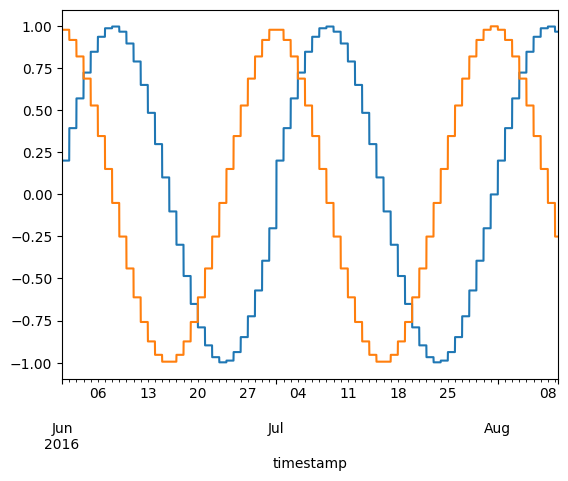

In [9]:
# plot the cyclic features

sample = data[0:10000]
ax = sample['day_sin'].plot()
ax = sample['day_cos'].plot()

In [ ]:
# ax = sample.plot.scatter('month_sin', 'month_cos').set_aspect('equal')

In [10]:
# Season
# data["season"] = data.index.month % 12 // 3
# one hot encode season column using values 0 and 1
# data = pd.get_dummies(data, columns=['season'])

# print(data.head())

# Shift the target variable for different horizons
data['power_next_step'] = data['power_(kw)'].shift(-1)
data['power_next_hour'] = data['power_(kw)'].shift(-6)  # Assuming 10-minute intervals
data['power_next_day'] = data['power_(kw)'].shift(-144)  # Assuming 10-minute intervals

# Drop rows with NaN values in the shifted columns
data.dropna(subset=['power_next_step', 'power_next_hour', 'power_next_day'], inplace=True)

data['power_1h_mean'] = data['power_(kw)'].rolling(window = 6).mean()
data['power_12h_mean'] = data['power_(kw)'].rolling(window = 6*12).mean()
data['power_24h_mean'] = data['power_(kw)'].rolling(window = 6*24).mean()
data['power_1h_std'] = data['power_(kw)'].rolling(window = 6).std()
data['power_12h_std'] = data['power_(kw)'].rolling(window = 6*12).std()
data['power_24h_std'] = data['power_(kw)'].rolling(window = 6*24).std()
data['power_1h_max'] = data['power_(kw)'].rolling(window = 6).max()
data['power_12h_max'] = data['power_(kw)'].rolling(window = 6*12).max()
data['power_24h_max'] = data['power_(kw)'].rolling(window = 6*24).max()
data['power_1h_min'] = data['power_(kw)'].rolling(window = 6).min()
data['power_12h_min'] = data['power_(kw)'].rolling(window = 6*12).min()
data['power_24h_min'] = data['power_(kw)'].rolling(window = 6*24).min()

# Split the data into training and test sets
train_data, test_data = data[:'2020-06-30'], data['2020-07-01':]
train_size = int(len(train_data) * 0.8)  # 80% for training
train_data, val_data = train_data[:train_size], train_data[train_size:]



In [11]:
train_data

,wind_speed_(m/s),long_term_wind_(m/s),wind_speed_sensor_1_(m/s),wind_speed_sensor_2_(m/s),density_adjusted_wind_speed_(m/s),wind_direction_(°),nacelle_position_(°),vane_position_1+2_(°),energy_export_(kwh),energy_export_counter_(kwh),energy_import_(kwh),energy_import_counter_(kwh),energy_budget___default_(kwh),energy_theoretical_(kwh),virtual_production_(kwh),power_(kw),potential_power_default_pc_(kw),potential_power_learned_pc_(kw),potential_power_reference_turbines_(kw),cascading_potential_power_(kw),cascading_potential_power_for_performance_(kw),potential_power_met_mast_anemometer_(kw),potential_power_primary_reference_turbines_(kw),potential_power_secondary_reference_turbines_(kw),turbine_power_setpoint_(kw),potential_power_estimated_(kw),potential_power_mpc_(kw),potential_power_met_mast_anemometer_mpc_(kw),available_capacity_for_production_(kw),available_capacity_for_production_(planned)_(kw),power_factor_(cosphi),reactive_power_(kvar),front_bearing_temperature_(°c),rear_bearing_temperature_(°c),stator_temperature_1_(°c),nacelle_ambient_temperature_(°c),nacelle_temperature_(°c),transformer_temperature_(°c),gear_oil_inlet_temperature_(°c),generator_bearing_rear_temperature_(°c),generator_bearing_front_temperature_(°c),gear_oil_temperature_(°c),temp._top_box_(°c),hub_temperature_(°c),ambient_temperature_(converter)_(°c),rotor_bearing_temp_(°c),transformer_cell_temperature_(°c),temperature_motor_axis_1_(°c),temperature_motor_axis_2_(°c),temperature_motor_axis_3_(°c),cpu_temperature_(°c),"generator_bearing_front_temperature,_std_(°c)","generator_bearing_rear_temperature,_std_(°c)",voltage_l1_/_u_(v),voltage_l2_/_v_(v),voltage_l3_/_w_(v),grid_voltage_(v),current_l1_/_u_(a),current_l2_/_v_(a),current_l3_/_w_(a),grid_current_(a),motor_current_axis_1_(a),motor_current_axis_2_(a),motor_current_axis_3_(a),rotor_speed_(rpm),generator_rpm_(rpm),gearbox_speed_(rpm),capacity_factor,production_based_iec_b.2.2_(users_view),production_based_iec_b.2.3_(users_view),production_based_iec_b.3.2_(manufacturers_view),production_based_system_avail.,production_based_contractual_avail.,production_based_system_avail._(virtual),production_based_contractual_avail._(global),production_based_contractual_avail._(custom),reactive_energy_export_(kvarh),reactive_energy_export_counter_(kvarh),reactive_energy_import_(kvarh),reactive_energy_import_counter_(kvarh),blade_angle_(pitch_position)_a_(°),blade_angle_(pitch_position)_b_(°),blade_angle_(pitch_position)_c_(°),yaw_bearing_angle_(°),gear_oil_inlet_pressure_(bar),gear_oil_pump_pressure_(bar),grid_frequency_(hz),equivalent_full_load_hours_(s),equivalent_full_load_hours_counter_(s),production_factor,performance_index,apparent_power_(kva),cable_windings_from_calibration_point,metal_particle_count,metal_particle_count_counter,drive_train_acceleration_(mm/ss),tower_acceleration_x_(mm/ss),tower_acceleration_y_(mm/ss),season,month,hour,quarter,year,day,hour_sin,hour_cos,month_sin,month_cos,quarter_sin,quarter_cos,season_sin,season_cos,day_sin,day_cos,power_next_step,power_next_hour,power_next_day,power_1h_mean,power_12h_mean,power_24h_mean,power_1h_std,power_12h_std,power_24h_std,power_1h_max,power_12h_max,power_24h_max,power_1h_min,power_12h_min,power_24h_min
timestamp,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-06-01 00:00:00,9.087127,5.3,NaN,NaN,9.051199,5.273296,358.049011,NaN,216.0,2104847.0,0.000000,646.0,78.563426,244.619186,216.0,1424.596924,1411.593227,1467.715114,1442.765894,1467.715114,1467.715114,NaN,1442.765894,NaN,NaN,NaN,1411.593227,NaN,2050.0,2050,-0.950909,-440.336395,70.584999,67.385002,66.727501,10.4000,14.9825,85.962502,41.570000,37.187500,29.360001,49.660000,21.200001,18.0,14.175000,30.549999,18.442499,NaN,NaN,NaN,NaN,NaN,NaN,399.436005,399.863098,399.650146,399.657196,1248.919556,1252.019531,1249.934204,1253.593018,NaN,NaN,NaN,14.968830,1775.010986,1778.652466,0.632195,1.0,1.0,1.0,1.0,1.0,1.0,NaN,NaN,0

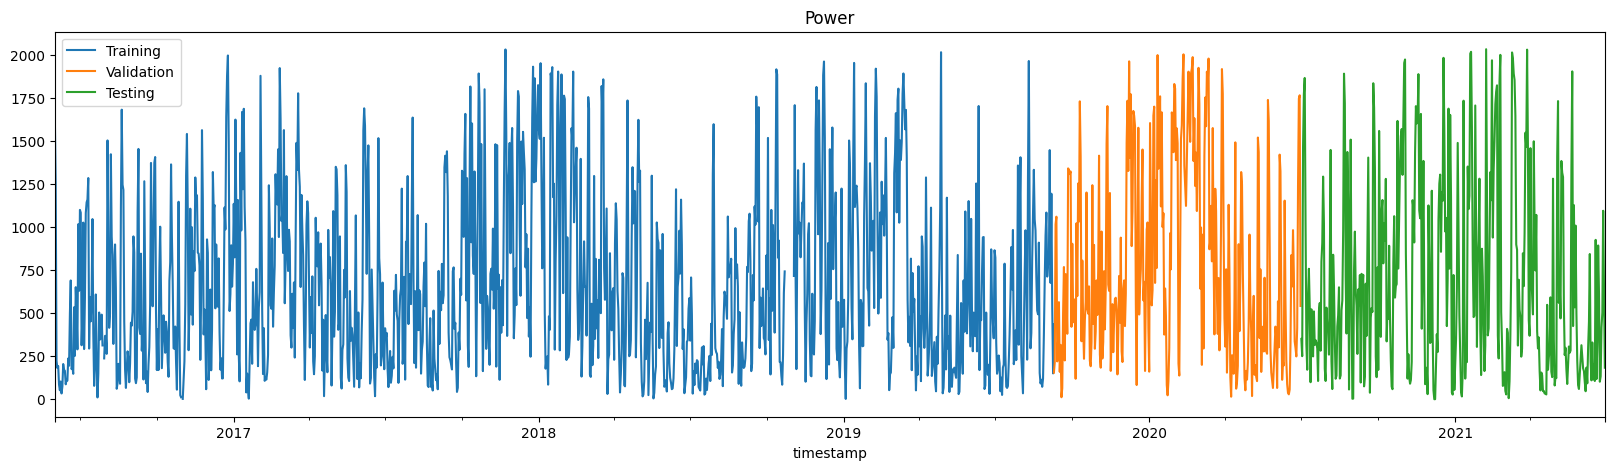

In [21]:
# period = slice('02-2020', '11-2020')
figure, ax = plt.subplots(figsize=(20, 5))
train_data.resample('D').mean().plot(ax=ax, label="Training", y="power_next_step")
val_data.resample('D').mean().plot(ax=ax, label="Validation", y="power_next_step")
test_data.resample('D').mean().plot(ax=ax, label="Testing",  y="power_next_step", title="Power")
plt.show()

In [ ]:
# get columns with correlation above 0.75 to 'power_(kw)'
# corr = data.corr()
# corr_cols = corr['power_(kw)'][corr['power_(kw)'] > 0.75].index
# features = list(corr_cols)
# Define the input features and target variables for different horizons
# features = ['wind_speed', 'ambient_temperature', 'wind_direction', 'season', 'long_term_wind']
# features list is all columns of df except for the target columns
features = list(data.columns)
features.remove('power_(kw)') if 'power_(kw)' in features else None
features.remove('power_next_step') if 'power_next_step' in features else None
features.remove('power_next_hour') if 'power_next_hour' in features else None
features.remove('power_next_day') if 'power_next_day' in features else None
target_next_step = 'power_next_step'
target_next_hour = 'power_next_hour'
target_next_day = 'power_next_day'

In [ ]:
features

['wind_speed_(m/s)',
 'long_term_wind_(m/s)',
 'wind_speed_sensor_1_(m/s)',
 'wind_speed_sensor_2_(m/s)',
 'density_adjusted_wind_speed_(m/s)',
 'wind_direction_(°)',
 'nacelle_position_(°)',
 'vane_position_1+2_(°)',
 'energy_export_(kwh)',
 'energy_export_counter_(kwh)',
 'energy_import_(kwh)',
 'energy_import_counter_(kwh)',
 'energy_budget___default_(kwh)',
 'energy_theoretical_(kwh)',
 'virtual_production_(kwh)',
 'potential_power_default_pc_(kw)',
 'potential_power_learned_pc_(kw)',
 'potential_power_reference_turbines_(kw)',
 'cascading_potential_power_(kw)',
 'cascading_potential_power_for_performance_(kw)',
 'potential_power_met_mast_anemometer_(kw)',
 'potential_power_primary_reference_turbines_(kw)',
 'potential_power_secondary_reference_turbines_(kw)',
 'turbine_power_setpoint_(kw)',
 'potential_power_estimated_(kw)',
 'potential_power_mpc_(kw)',
 'potential_power_met_mast_anemometer_mpc_(kw)',
 'available_capacity_for_production_(kw)',
 'available_capacity_for_production_(

In [ ]:
features.extend(["season", "month", "hour", "quarter", "year", "power_1h_mean", "power_12h_mean", "power_24h_mean", "power_1h_std", "power_12h_std", "power_24h_std", "power_1h_max", "power_12h_max", "power_24h_max", "power_1h_min", "power_12h_min", "power_24h_min"])
features = list(set(features))
features

['gearbox_speed_(rpm)',
 'power_12h_min',
 'cascading_potential_power_for_performance_(kw)',
 'temperature_motor_axis_3_(°c)',
 'quarter_cos',
 'hour',
 'power_12h_max',
 'front_bearing_temperature_(°c)',
 'power_24h_min',
 'power_24h_std',
 'hub_temperature_(°c)',
 'gear_oil_inlet_pressure_(bar)',
 'production_factor',
 'production_based_iec_b.2.3_(users_view)',
 'potential_power_met_mast_anemometer_(kw)',
 'equivalent_full_load_hours_counter_(s)',
 'blade_angle_(pitch_position)_a_(°)',
 'day_cos',
 'season_sin',
 'temperature_motor_axis_2_(°c)',
 'reactive_energy_export_(kvarh)',
 'ambient_temperature_(converter)_(°c)',
 'gear_oil_pump_pressure_(bar)',
 'wind_speed_(m/s)',
 'potential_power_primary_reference_turbines_(kw)',
 'potential_power_estimated_(kw)',
 'voltage_l3_/_w_(v)',
 'current_l2_/_v_(a)',
 'current_l3_/_w_(a)',
 'metal_particle_count_counter',
 'nacelle_ambient_temperature_(°c)',
 'motor_current_axis_1_(a)',
 'virtual_production_(kwh)',
 'production_based_contractual_a

In [ ]:
# Prepare the training and test data for different horizons
X_train, y_train_next_step = train_data[features], train_data[target_next_step]
X_val, y_val_next_step = val_data[features], val_data[target_next_step]
X_test, y_test_next_step = test_data[features], test_data[target_next_step]

X_train, y_train_next_hour = train_data[features], train_data[target_next_hour]
X_val, y_val_next_hour = val_data[features], val_data[target_next_hour]
X_test, y_test_next_hour = test_data[features], test_data[target_next_hour]

X_train, y_train_next_day = train_data[features], train_data[target_next_day]
X_val, y_val_next_day = val_data[features], val_data[target_next_day]
X_test, y_test_next_day = test_data[features], test_data[target_next_day]


NameError: name 'train_data' is not defined

In [ ]:
# Train the XGBoost model for the next step prediction
model_next_step = xgb.XGBRegressor(n_estimators=500, max_depth=5, eta=0.1, subsample=0.7, colsample_bytree=0.8,)
model_next_step.fit(X_train, y_train_next_step, eval_set=[(X_val, y_val_next_step)], early_stopping_rounds=50, verbose=True)

# Perform hyper parameter tuning
# model_next_step = xgb.XGBRegressor()
# param_dist = {
#                 "max_depth": [5, 25, 50],
#                 "n_estimators": [500, 1000],
#                 "reg_lambda": [0, 0.5, 1, 5]
#             }
# grid_search = GridSearchCV(model_next_step, param_grid=param_dist, cv = 3, verbose=10, n_jobs=-1)
# grid_search.fit(X_train, y_train_next_step)
# grid_search.best_estimator_

xgb.plot_importance(model_next_step)

# Make predictions for the next step
y_pred_next_step = model_next_step.predict(X_test)

# Evaluate the next step predictions
mse_next_step = mean_squared_error(y_test_next_step, y_pred_next_step)
mae_next_step = mean_absolute_error(y_test_next_step, y_pred_next_step)
print(f"Mean Squared Error (Next Step): {mse_next_step}")
print(f"Mean Absolute Error (Next Step): {mae_next_step}")
print(f"RMSE (Next Step): {mse_next_step ** 0.5}")


/Users/lena/Code/uni/ss23/mlses/mlses-wind-power-forecast/.venv/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-rmse:966.17220
[1]	validation_0-rmse:878.95477
[2]	validation_0-rmse:801.47653
[3]	validation_0-rmse:732.36152
[4]	validation_0-rmse:670.99639
[5]	validation_0-rmse:616.51105
[6]	validation_0-rmse:568.62234
[7]	validation_0-rmse:526.11638
[8]	validation_0-rmse:489.52182
[9]	validation_0-rmse:457.42805
[10]	validation_0-rmse:429.25210
[11]	validation_0-rmse:404.96548
[12]	validation_0-rmse:383.80537
[13]	validation_0-rmse:365.97888
[14]	validation_0-rmse:350.72988
[15]	validation_0-rmse:337.81783
[16]	validation_0-rmse:326.84353
[17]	validation_0-rmse:317.77645
[18]	validation_0-rmse:309.83287
[19]	validation_0-rmse:303.46347
[20]	validation_0-rmse:298.07653
[21]	validation_0-rmse:293.48912
[22]	validation_0-rmse:289.65134
[23]	validation_0-rmse:286.48149
[24]	validation_0-rmse:284.02303
[25]	validation_0-rmse:281.89163
[26]	validation_0-rmse:280.12207
[27]	validation_0-rmse:278.63053
[28]	validation_0-rmse:277.36579
[29]	validation_0-rmse:276.35003
[30]	validation_0-rm

/Users/lena/Code/uni/ss23/mlses/mlses-wind-power-forecast/.venv/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-rmse:1000.24108
[1]	validation_0-rmse:943.48647
[2]	validation_0-rmse:895.91972
[3]	validation_0-rmse:853.42954
[4]	validation_0-rmse:828.30654
[5]	validation_0-rmse:796.13102
[6]	validation_0-rmse:770.38738
[7]	validation_0-rmse:748.32927
[8]	validation_0-rmse:729.41335
[9]	validation_0-rmse:713.01090
[10]	validation_0-rmse:703.47618
[11]	validation_0-rmse:700.11404
[12]	validation_0-rmse:689.01091
[13]	validation_0-rmse:680.68386
[14]	validation_0-rmse:672.99284
[15]	validation_0-rmse:669.37484
[16]	validation_0-rmse:662.38038
[17]	validation_0-rmse:656.71450
[18]	validation_0-rmse:652.63825
[19]	validation_0-rmse:647.12087
[20]	validation_0-rmse:644.42317
[21]	validation_0-rmse:640.93703
[22]	validation_0-rmse:637.85073
[23]	validation_0-rmse:634.53961
[24]	validation_0-rmse:631.85308
[25]	validation_0-rmse:630.03677
[26]	validation_0-rmse:627.92154
[27]	validation_0-rmse:626.91473
[28]	validation_0-rmse:625.71956
[29]	validation_0-rmse:624.13996
[30]	validation_0-r

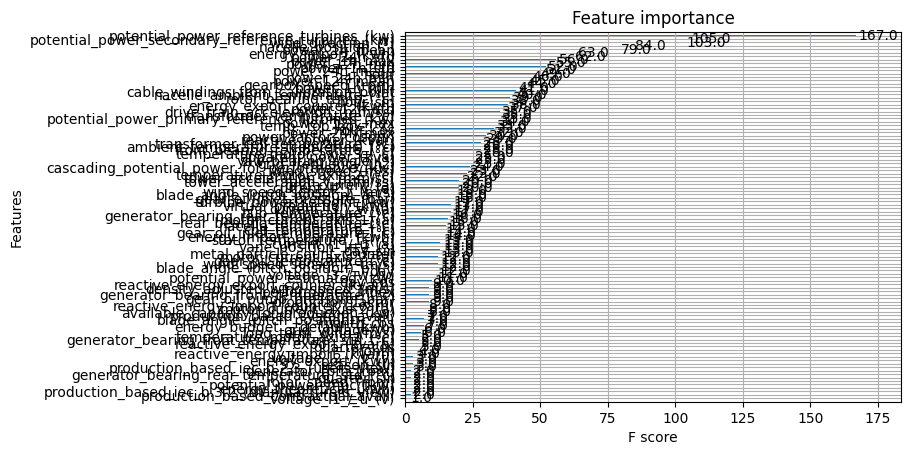

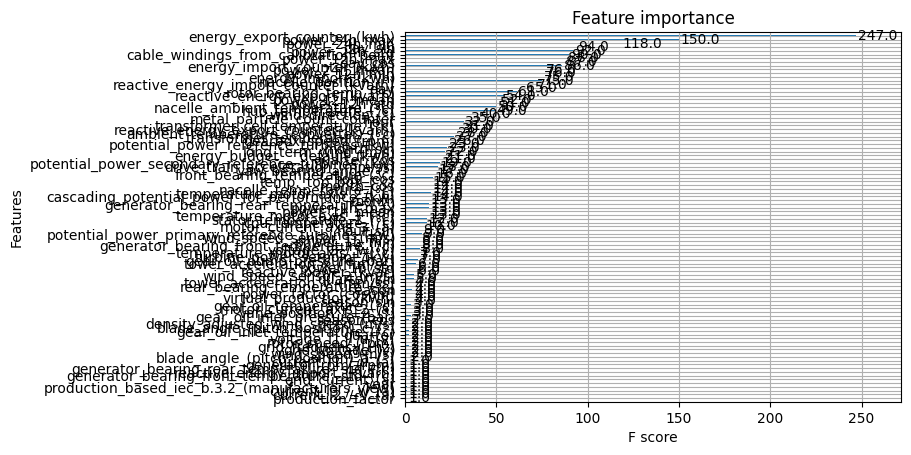

In [ ]:

# Train the XGBoost model for the next hour prediction
model_next_hour = xgb.XGBRegressor(n_estimators=500, max_depth=5, eta=0.1, subsample=0.7, colsample_bytree=0.8)
model_next_hour.fit(X_train, y_train_next_hour, eval_set=[(X_val, y_val_next_hour)], early_stopping_rounds=50, verbose=True)


xgb.plot_importance(model_next_hour)

# Make predictions for the next hour
y_pred_next_hour = model_next_hour.predict(X_test)

# Evaluate the next hour predictions
mse_next_hour = mean_squared_error(y_test_next_hour, y_pred_next_hour)
mae_next_hour = mean_absolute_error(y_test_next_hour, y_pred_next_hour)
print(f"Mean Squared Error (Next Hour): {mse_next_hour}")
print(f"Mean Absolute Error (Next Hour): {mae_next_hour}")
print(f"RMSE (Next Hour): {mse_next_hour ** 0.5}")

# Train the XGBoost model for the next day prediction
model_next_day = xgb.XGBRegressor(n_estimators=500, max_depth=5, eta=0.1, subsample=0.7, colsample_bytree=0.8)
model_next_day.fit(X_train, y_train_next_day, eval_set=[(X_val, y_val_next_day)], early_stopping_rounds=50, verbose=True)


xgb.plot_importance(model_next_day)

# Make predictions for the next day
y_pred_next_day = model_next_day.predict(X_test)

# Evaluate the next day predictions
mse_next_day = mean_squared_error(y_test_next_day, y_pred_next_day)
mae_next_day = mean_absolute_error(y_test_next_day, y_pred_next_day)
print(f"Mean Squared Error (Next Day): {mse_next_day}")
print(f"Mean Absolute Error (Next Day): {mae_next_day}")
print(f"RMSE (Next Day): {mse_next_day ** 0.5}")

In [ ]:
# get most important features
feature_importances_next = pd.DataFrame(model_next_step.feature_importances_*100, index = X_train.columns, columns=['importance_step']).sort_values('importance_step', ascending=False)
feature_importances_hour = pd.DataFrame(model_next_hour.feature_importances_*100, index = X_train.columns, columns=['importance_hour']).sort_values('importance_hour', ascending=False)
feature_importances_day = pd.DataFrame(model_next_day.feature_importances_*100, index = X_train.columns, columns=['importance_day']).sort_values('importance_day', ascending=False)

# average feature importances together for next step, next hour and next day
feature_importances = pd.concat([feature_importances_next, feature_importances_hour, feature_importances_day], axis=1)
feature_importances['average_importance'] = feature_importances.mean(axis=1)
feature_importances = feature_importances.sort_values('average_importance', ascending=False)
feature_importances.to_csv("feature_importances.csv")

In [ ]:
# drop features with importance less than 1%
best_features = feature_importances[feature_importances['average_importance'] > 0.01]
best_features = best_features.index.tolist()
best_features

['current_l1_/_u_(a)',
 'current_l3_/_w_(a)',
 'apparent_power_(kva)',
 'grid_current_(a)',
 'current_l2_/_v_(a)',
 'power_1h_mean',
 'power_1h_max',
 'potential_power_primary_reference_turbines_(kw)',
 'potential_power_reference_turbines_(kw)',
 'quarter_cos',
 'month_cos',
 'density_adjusted_wind_speed_(m/s)',
 'reactive_power_(kvar)',
 'cascading_potential_power_for_performance_(kw)',
 'generator_rpm_(rpm)',
 'energy_import_(kwh)',
 'season',
 'reactive_energy_export_(kvarh)',
 'yaw_bearing_angle_(°)',
 'long_term_wind_(m/s)',
 'reactive_energy_import_(kvarh)',
 'nacelle_position_(°)',
 'power_12h_max',
 'power_24h_max',
 'energy_budget___default_(kwh)',
 'wind_direction_(°)',
 'quarter',
 'reactive_energy_import_counter_(kvarh)',
 'cable_windings_from_calibration_point',
 'month',
 'energy_export_counter_(kwh)',
 'day_sin',
 'day',
 'gear_oil_pump_pressure_(bar)',
 'metal_particle_count_counter',
 'power_24h_min',
 'energy_import_counter_(kwh)',
 'power_24h_std',
 'virtual_producti

In [ ]:
# plot the highest correlated features
corr.style.background_gradient(cmap='coolwarm')

/Users/lena/Code/uni/ss23/mlses/mlses-wind-power-forecast/.venv/lib/python3.11/site-packages/pandas/io/formats/style.py:3618: RuntimeWarning: All-NaN slice encountered
  smin = np.nanmin(gmap) if vmin is None else vmin
/Users/lena/Code/uni/ss23/mlses/mlses-wind-power-forecast/.venv/lib/python3.11/site-packages/pandas/io/formats/style.py:3619: RuntimeWarning: All-NaN slice encountered
  smax = np.nanmax(gmap) if vmax is None else vmax


In [ ]:
# pca on data to get important features
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(X_train)
principalDf = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2'])
finalDf = pd.concat([principalDf, y_train_next_step], axis = 1)
finalDf.head(5)



<Axes: >

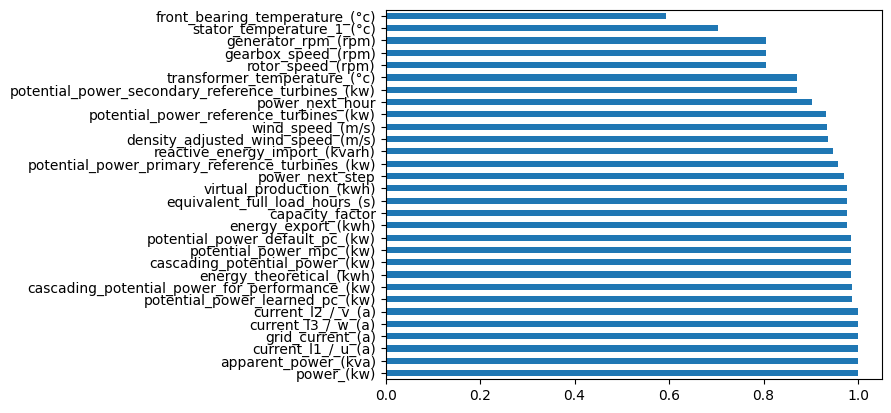

In [ ]:
# plot the highest correlated features for column 'power_(kw)'
corr['power_(kw)'].sort_values(ascending=False).head(30).plot(kind='barh')

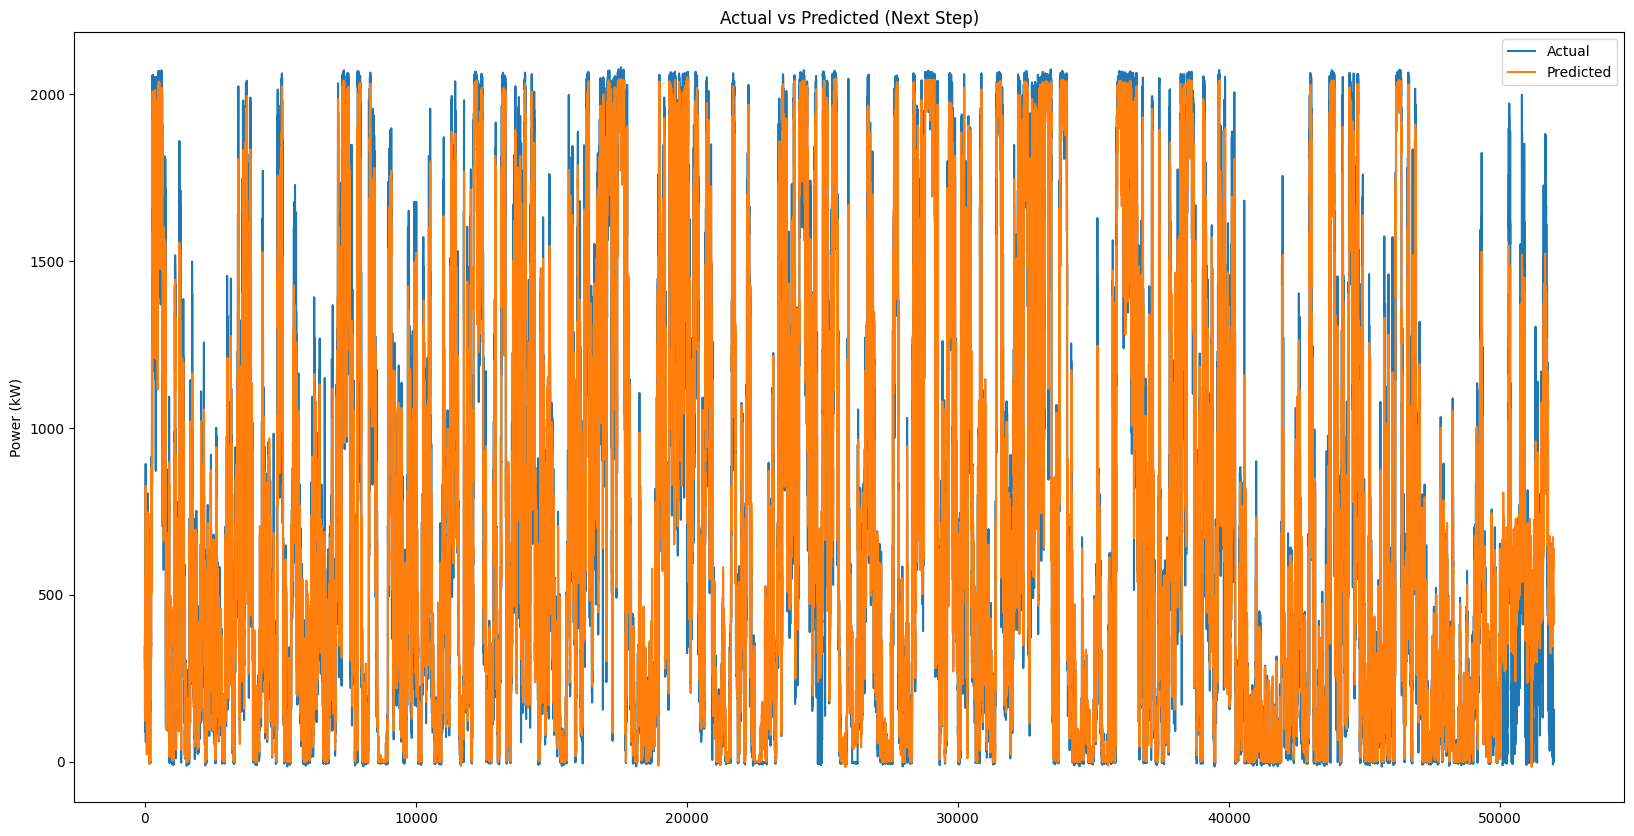

In [ ]:
# Plot the actual and predicted values for the next step
plt.figure(figsize=(20, 10))
plt.plot(y_test_next_step.values, label='Actual')
plt.plot(y_pred_next_step, label='Predicted')
plt.title('Actual vs Predicted (Next Step)')
plt.ylabel('Power (kW)')
plt.legend()
plt.show()

In [ ]:
# get the feature importance scores with feature names
feature_importances = pd.DataFrame(model_next_step.feature_importances_,
                                      index=X_train.columns,
                                        columns=['importance']).sort_values('importance', ascending=False)
feature_importances.sort_values(by='importance', ascending=False).to_dict()['importance']


{'apparent_power_(kva)': 0.30162304639816284,
 'current_l2_/_v_(a)': 0.2602079212665558,
 'current_l1_/_u_(a)': 0.2106269896030426,
 'grid_current_(a)': 0.15477831661701202,
 'current_l3_/_w_(a)': 0.04008062556385994,
 'gearbox_speed_(rpm)': 0.003582012839615345,
 'potential_power_mpc_(kw)': 0.0019330496434122324,
 'rotor_speed_(rpm)': 0.0018661556532606483,
 'potential_power_reference_turbines_(kw)': 0.001761997235007584,
 'energy_theoretical_(kwh)': 0.0015122001059353352,
 'generator_rpm_(rpm)': 0.0014108361210674047,
 'potential_power_default_pc_(kw)': 0.0013640930410474539,
 'cascading_potential_power_for_performance_(kw)': 0.0011745183728635311,
 'capacity_factor': 0.0010688956826925278,
 'energy_export_(kwh)': 0.0009270536829717457,
 'density_adjusted_wind_speed_(m/s)': 0.0008803972159512341,
 'potential_power_learned_pc_(kw)': 0.000779546913690865,
 'season': 0.0007418083841912448,
 'power_1h_min': 0.0007352895336225629,
 'power_1h_max': 0.0007001078338362277,
 'transformer_temp

In [ ]:
model_next_step.feature_importances_

array([8.25189418e-05, 7.53283821e-05, 5.05157746e-04, 3.07678565e-04,
       2.67754571e-04, 5.41535905e-04, 9.93355279e-05, 1.46825871e-04,
       2.82361318e-04, 1.82972301e-03, 0.00000000e+00, 1.36040311e-04,
       1.42023596e-03, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       1.24306782e-04, 1.79080496e-04, 3.68265493e-04, 8.93053802e-05,
       8.38895561e-04, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       1.14132752e-04, 7.65378913e-03, 1.37266458e-03, 0.00000000e+00,
       0.00000000e+00, 3.34043143e-04, 2.01003611e-04, 0.00000000e+00,
       1.20870897e-03, 0.00000000e+00, 2.19178677e-04, 2.26001357e-04,
       9.21728351e-05, 1.67881706e-04, 1.45981860e-04, 1.13402166e-04,
       1.80646311e-04, 2.88562209e-04, 1.87116268e-04, 1.03993028e-04,
      